In [1]:
# Import Libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions import *
%matplotlib inline

## Load Datasets from CSV Files

In [2]:
# Read CSV files containing sales transactions and temperatures
pathfile = './datasets/'
data_years = ['2018', '2019', '2020', '2021']


# Load datasets with sales between 2014 and 2019
filename = 'y_'
df_sales = pd.read_csv(pathfile + filename + '2017.csv', infer_datetime_format = True, encoding = 'latin-1')
print('Initiall Shape df_sales: {}, year: 2017'.format(df_sales.shape) )

for year in data_years:
    df = pd.read_csv(pathfile + filename + year + '.csv', infer_datetime_format = True, encoding = 'latin-1')
    df_sales = pd.concat([df_sales, df], ignore_index=True)
    print('Shapes df: {}, df_sales: {}, year: {}'.format(df.shape, df_sales.shape, year) )

# Read dataset with Minimum Phoenix Temperatures
df_min_temp = pd.read_csv(pathfile + 'phx_min_temp.csv', sep='\t', encoding = 'utf-8')

# Read dataset with Maximum Phoenix Temperatures
df_max_temp = pd.read_csv(pathfile + 'phx_max_temp.csv', sep='\t', encoding = 'utf-8')

df_tmp = None

Initiall Shape df_sales: (25030, 11), year: 2017
Shapes df: (27331, 11), df_sales: (52361, 11), year: 2018
Shapes df: (27993, 11), df_sales: (80354, 11), year: 2019
Shapes df: (26658, 11), df_sales: (107012, 11), year: 2020
Shapes df: (9495, 11), df_sales: (116507, 11), year: 2021


In [3]:
df_sales.head()

,Unnamed: 0,Type,Date,Num,Memo,Name,Item,Qty,Sales Price,Amount,Balance
0,Inventory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00-Beer & Spirits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"00177USA - R2 Casino Azul Blanc (Casino Azul, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Invoice,01/18/2017,70229,"Casino Azul, Tequila Blanco",Total Wine 1006,00-Beer & Spirits:00177USA - R2 Casino Azul Bl...,6.0,29.95,179.7,179.7
4,NaN,Invoice,01/18/2017,70233,"Casino Azul, Tequila Blanco",Total Wine 1004,00-Beer & Spirits:00177USA - R2 Casino Azul Bl...,6.0,29.95,179.7,359.4


## Data Preprocessing

In [4]:
# Dictionary with interesting Products for the project
target_items = {'70270':'Le Contesse, Prosecchino Brut, 187ml',
                '20209':'Alverdi, Pinot Grigio',
                '70165':'Santome, Prosecco Extra Dry',
                '50215':'Carpineto, Dogajolo Rosso',
                '70208':'Italo Cescon, Pinot Grigio',
                '70271':'Le Contesse, Pinot Noir Rose Brut'
               }
df_sales = clean_sales(df_sales, list(target_items.keys()))
df_sales.head()

Final Dataset Shape: (8433, 5)


,quantity,price,item_code,month,year
5623,7.0,6.99,20209,1,2017
5624,12.0,6.99,20209,1,2017
5625,12.0,6.99,20209,1,2017
5626,12.0,6.99,20209,1,2017
5627,6.0,6.99,20209,1,2017


Check for NaN's Values

In [5]:
print('Null values:\n{}'.format(df_sales.isnull().sum())) # Display Null values per Column
print(df_sales[df_sales['price'].isnull()]) # Display rows with Null values

Null values:
quantity     0
price        1
item_code    0
month        0
year         0
dtype: int64
        quantity  price item_code  month  year
100379       2.0    NaN     70271      5  2020


Imputate average price for 1 row with Nan value

In [6]:
df_sales.loc[100379,'price'] = df_sales.price[df_sales['item_code']=='70271'].mean()
print('Null values:\n{}'.format(df_sales.isnull().sum())) # Display Null values per Column

Null values:
quantity     0
price        0
item_code    0
month        0
year         0
dtype: int64


Create Time Series for each product by Month

In [7]:
df = df_sales.groupby(by=['item_code','year','month'], as_index=False).agg(
    quantity=('quantity','sum'), 
    avg_price=('price', np.mean)
) # Group by item, month and year to result in a time series for each product
df['day'] = "01"
df['date'] = pd.to_datetime(df[['year','month','day']]) # Create a date column using year, month and day
df.drop(['month','day','year'], axis=1, inplace=True) # Drop day, month and year columns
df.head()

,item_code,quantity,avg_price,date
0,20209,109.0,6.990000,2017-01-01
1,20209,136.0,7.144666,2017-02-01
2,20209,129.0,6.990000,2017-03-01
3,20209,190.0,6.990000,2017-04-01
4,20209,172.0,6.990000,2017-05-01


Check the number of Data Points per Item

In [8]:
for item, values in target_items.items():
    print('Item: {}, Data Points:{}, {}'.format(item, df.date[df['item_code']==item].count(), values))

Item: 70270, Data Points:48, Le Contesse, Prosecchino Brut, 187ml
Item: 20209, Data Points:52, Alverdi, Pinot Grigio
Item: 70165, Data Points:52, Santome, Prosecco Extra Dry
Item: 50215, Data Points:52, Carpineto, Dogajolo Rosso
Item: 70208, Data Points:52, Italo Cescon, Pinot Grigio
Item: 70271, Data Points:43, Le Contesse, Pinot Noir Rose Brut


In [9]:
# Remove rows with date ='2021-04-01' since April 2021 data is incomplete
df.drop(df[df['date'] == '2021-04-01'].index, axis=0, inplace = True)
df.shape

(293, 4)

## Additional Features

The next section adds 2 new features to dataset:
- Phoenix Minimum Temperatures
- Phoenix Maximum Temperatures
- Log of 'quantity'

In [10]:
# Perform cleanning and formatting to temperature datasets
df_min_temp_transformed = extract_temperature(df_min_temp, new_colum_name='min_temp')
df_max_temp_transformed = extract_temperature(df_max_temp, new_colum_name='max_temp')
print('Shapes: Min Temp: {}, Max Temp:{}'.format(df_min_temp_transformed.shape, df_max_temp_transformed.shape))

Shapes: Min Temp: (84, 2), Max Temp:(84, 2)


In [11]:
# Perform a inner join between transformed temperatures datasets
df_transformed = pd.merge(df_min_temp_transformed,
                          df_max_temp_transformed,
                          how='inner',
                          on='date'                          
                         )
print(f'Shape: {df_transformed.shape}')

Shape: (84, 3)


In [12]:
df = pd.merge(df,
              df_transformed,
              how='inner',
              on='date'
             )
print(f'Shape: {df.shape}')

Shape: (293, 6)


In [13]:
df['log_quantity'] = np.log(df.quantity + 1e-8)
df['month'] = df["date"].dt.month.astype(str).astype('category')

In [14]:
# Filter 36 samples by product
df = df[df['date']>='2017-12-01']

# Print number of observations by Product
for item, values in target_items.items():
    print('Item: {}, Data Points:{}, {}'.format(item, df.date[df['item_code']==item].count(), values))

Item: 70270, Data Points:40, Le Contesse, Prosecchino Brut, 187ml
Item: 20209, Data Points:40, Alverdi, Pinot Grigio
Item: 70165, Data Points:40, Santome, Prosecco Extra Dry
Item: 50215, Data Points:40, Carpineto, Dogajolo Rosso
Item: 70208, Data Points:40, Italo Cescon, Pinot Grigio
Item: 70271, Data Points:40, Le Contesse, Pinot Noir Rose Brut


## Dataset Description

Feature Description:

"item_code": Code reference uses to identify the product</br>
"quantity": Indicate the number of bottle sold for the corresponding month</br>
"avg_price": Average price of the product for the indicated month</br>
"date": Monthly date to denotate time series sequence</br>
"min_temp": Reflect the minimum temperatures measured in Phoenix Arizona during the month</br>
"max_temp": Reflect the maximum temperatures measured in Phoenix Arizona during the month</br>

In [15]:
df.head()

,item_code,quantity,avg_price,date,min_temp,max_temp,log_quantity,month
53,20209,168.0,6.990000,2017-12-01,36,84,5.123964,12
54,50215,453.0,9.898158,2017-12-01,36,84,6.115892,12
55,70165,808.0,9.823333,2017-12-01,36,84,6.694562,12
56,70208,664.0,10.666764,2017-12-01,36,84,6.498282,12
57,70270,56.0,3.250000,2017-12-01,36,84,4.025352,12


## Visualization by Product

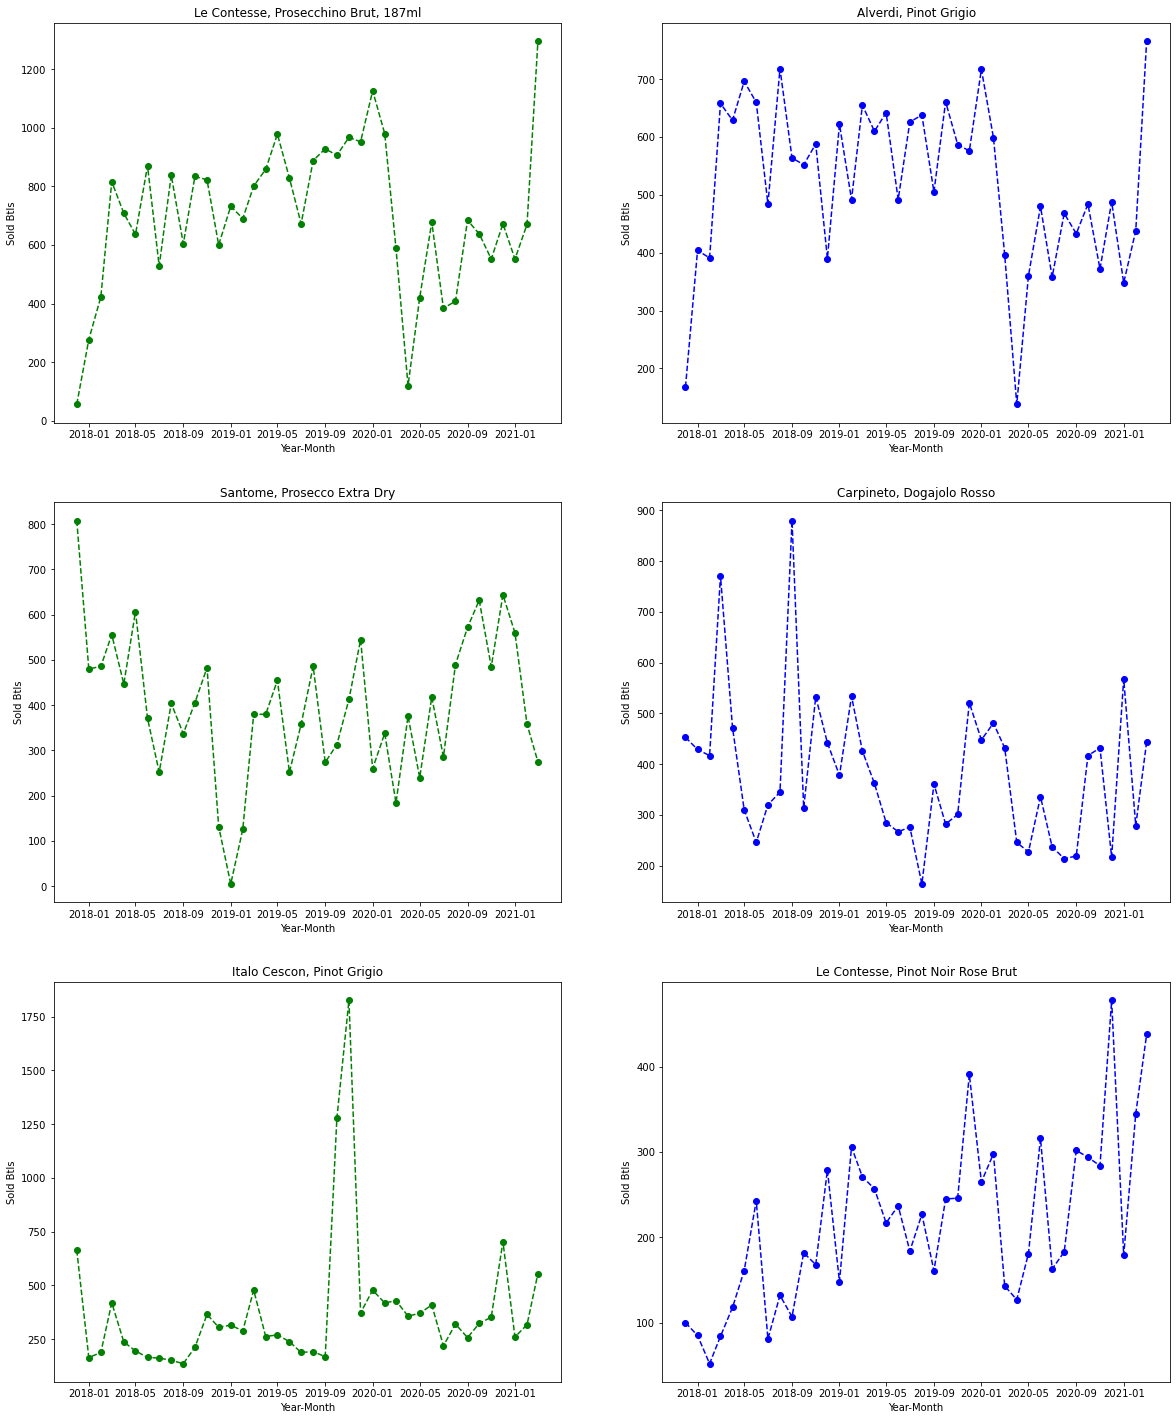

In [16]:
plot_item(df, list(target_items.keys()), list(target_items.values()), ['go--','bo--','go--','bo--','go--','bo--'] )

# Important points to address:
1) Most of products present very low sales in the following months of 2020: March, April and May. It is explained since 2020 was hit by pandemic COVID-19 and specially on those months goverment closed business operations leading to decrease sales sharply.</br>

2) Product 70208 Italo Cescon, Pinot Grigio showed a huge peak in months October and November 2019 which is explained by a special one time promo run for a retailer customer. Since I do not have a features to represent special promos, I will normalize those 2 points in order to help the model to deal with that.</br>

To normalize the previous cases, I will replace those point for averages of the same months on previous and future years to 2020.

For Instance 20209 Alverdi, Pinot Grigio:

March_2020 = (March_2017 + March_2018 + March_2019 + March_2021) / 4


In [17]:
# Compute Average of months affected by Pandemic COVID-19 and replace the values in 2019

month_list = ['3','4','5']
for item_code, values in target_items.items():
    for month in month_list:
        date_to_replace = '2020-'+ month + '-01'
        # Filter rows for the month specified by 'month' and take off 2020 data point for the month
        conditions = (df['item_code']== item_code) & (df['month']== month) & (df['date']!= date_to_replace)
        # Filter 2020 month data point to be replaced by average of month data points for the years different to 2020
        conditions1 =(df['date']== date_to_replace) & (df['item_code']==item_code)
        # Assign the average calculation to 2020 data point
        df.loc[conditions1, 'quantity'] = df[conditions].quantity.mean()
#         print(df[(df['date']== date_to_replace) & (df['item_code']==item_code)][['date','month','item_code','quantity']])

# Imputation for 70165 Santome Prosecco since Jan-2019 the product was out of stock since container was delayed
conditions1 = (df['item_code']== '70165') & (df['month']== '1') & (df['date']!= '2019-01-01')
conditions1 = (df['item_code']== '70165') & (df['date']== '2019-01-01')
df.loc[conditions1, 'quantity'] = df[conditions].quantity.mean()

In [18]:
# Compute average for months 10, 11 in product Italo Cescon PG, then impute the average for the same months in 2019

conditions = (df['item_code']=='70208') & (df['month']=='10')
df[conditions]


month_list = ['10','11']
item_code ='70208'

for month in month_list:
    date_to_replace = '2019-'+ month + '-01'
    # Filter rows for the month specified by 'month' and take off 2019 data point for the month
    conditions = (df['item_code']== item_code) & (df['month']== month) & (df['date']!= date_to_replace)
    # Filter 2020 month data point to be replaced by average of month data points for the years different to 2020
    conditions1 =(df['date']== date_to_replace) & (df['item_code']==item_code)
    # Assign the average calculation to 2020 data point
    df.loc[conditions1, 'quantity'] = df[conditions].quantity.mean()

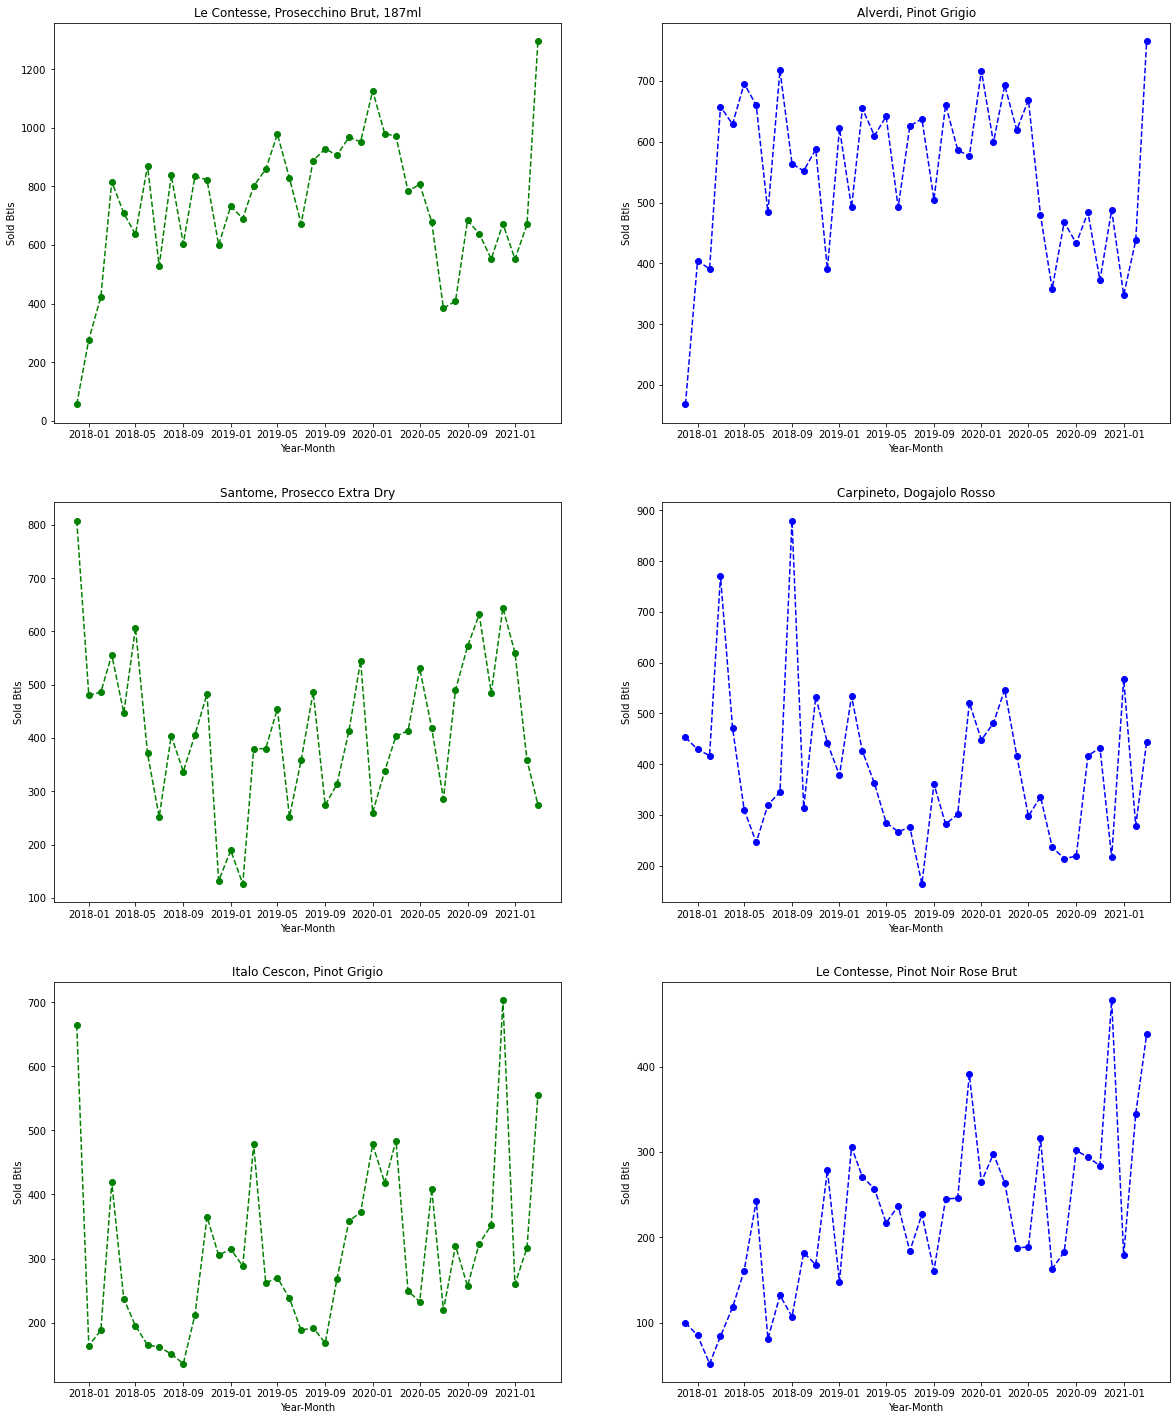

In [19]:
plot_item(df, list(target_items.keys()), list(target_items.values()), ['go--','bo--','go--','bo--','go--','bo--'] )

## Simple Moving Average Benchmark

Moving average 4 month will be our measurement to compare the performance of our model. The metrics used is MAE, MAPE.

In [20]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# Create an empty DataFrame to storage the error values
df_error = pd.DataFrame(columns = ['item_code','item_name','MAE','MAPE'])

for item_code, item_name in target_items.items():
    conditions = (df['item_code']== item_code)
    
    # Compute Simple Moving Average 4
    df.loc[conditions, 'sma4'] = df[conditions].quantity.rolling(window=4).mean()

    # Calculate MAE for last 4 data points to be compared to model
    y_true = df[conditions].quantity[-4:] 
    y_pred = df[conditions].sma4[-4:]

    MAE = mean_absolute_error(y_true, y_pred)
    MAPE = mean_absolute_percentage_error(y_true, y_pred)
#     print(f'MAE: {MAE}')
    df_error = df_error.append({'item_code': item_code,
                                'item_name': item_name,
                                'MAE': MAE,
                                'MAPE': MAPE
                               }, ignore_index = True )
df_error

,item_code,item_name,MAE,MAPE
0,70270,"Le Contesse, Prosecchino Brut, 187ml",161.0000,0.154521
1,20209,"Alverdi, Pinot Grigio",100.3125,0.174969
2,70165,"Santome, Prosecco Extra Dry",104.7500,0.307491
3,50215,"Carpineto, Dogajolo Rosso",106.4375,0.313157
4,70208,"Italo Cescon, Pinot Grigio",157.7500,0.363513
5,70271,"Le Contesse, Pinot Noir Rose Brut",92.4375,0.315202


In [23]:
# Overall MAE value for SMA4
print(f'Overall MAE = {df_error.MAE.mean()}')

Overall MAE = 120.44791666666667


<function matplotlib.pyplot.show(close=None, block=None)>

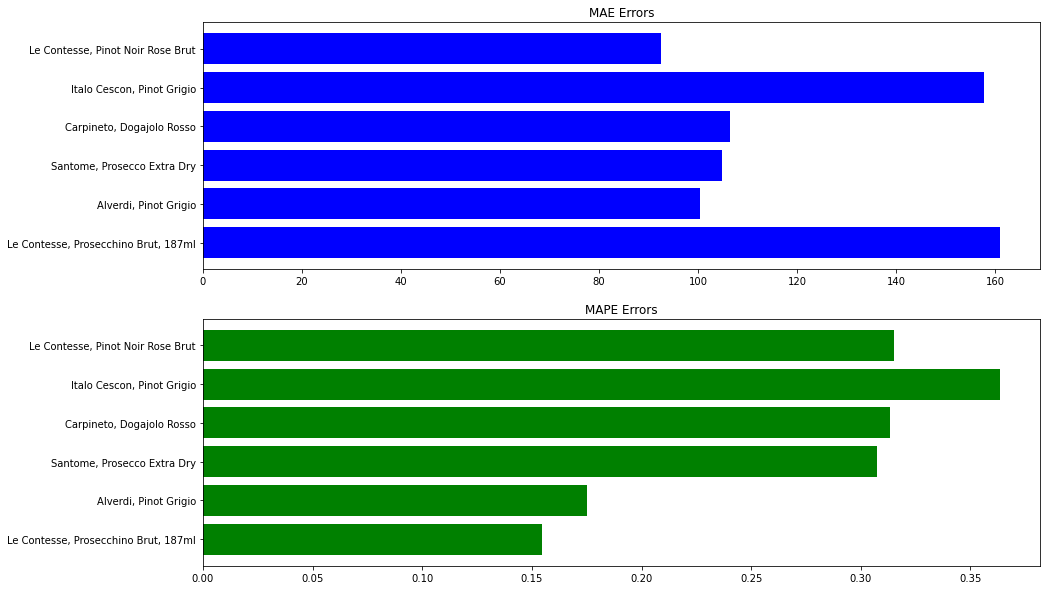

In [24]:
# Bar chart to show errors by item

fig, ax = plt.subplots(2, 1, figsize=(15,10))
ax[0].barh(df_error.item_name, df_error.MAE, color = 'b')
ax[0].set_title('MAE Errors')


ax[1].barh(df_error.item_name, df_error.MAPE, color='g')
ax[1].set_title('MAPE Errors')

plt.show

### Display Actual Sales vs SMA4 with the correspondent Error values

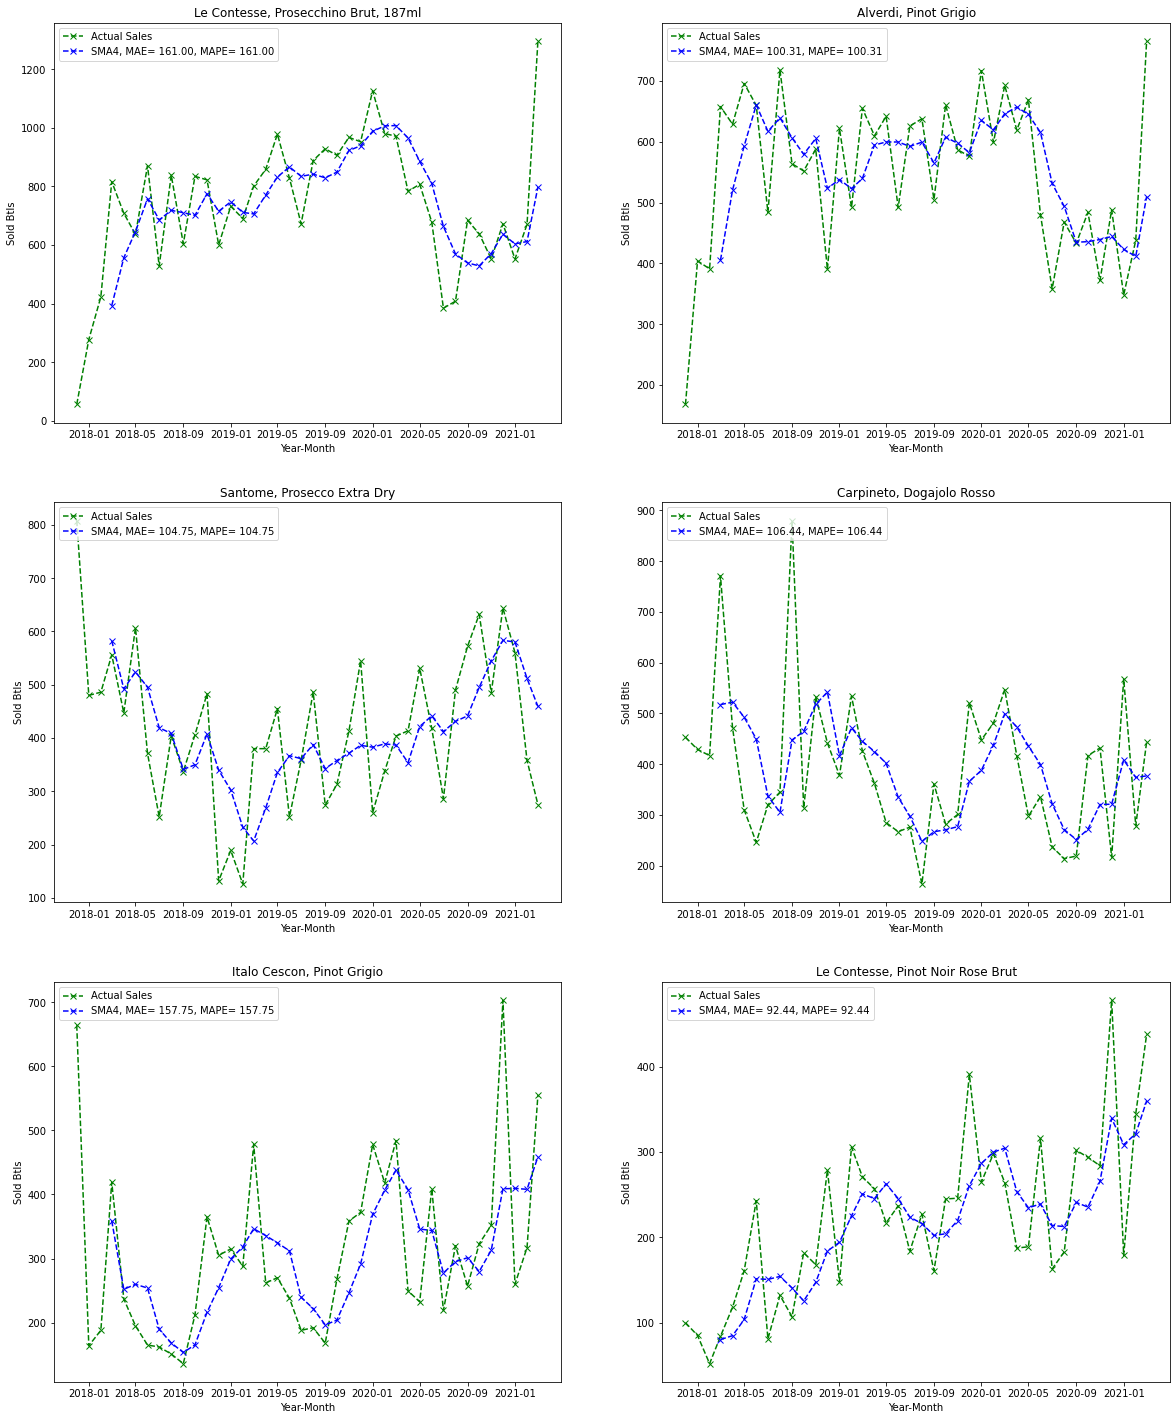

In [25]:
fig, ax = plt.subplots(3, 2, figsize=(20,25))

r = 0 # Denote the row for the Subplot
c = 0 # Denote the col for the Subplot

for item_code, item_name in target_items.items():
    item_set = df[df['item_code']==item_code]
    ax[r][c].plot(item_set['date'], item_set['quantity'], 'gx--')
    ax[r][c].plot(item_set['date'], item_set['sma4'], 'bx--')

    ax[r][c].set_xlabel('Year-Month')
    ax[r][c].set_ylabel('Sold Btls')
    ax[r][c].set_title(item_name)
    
    # Extract Error for SMA4
    MAE, MAPE = df_error[df_error['item_code'] == item_code].reset_index().loc[0,['MAE','MAPE']]
    sma_label = 'SMA4, MAE= {0:.2f}, MAPE= {0:.2f}'.format(MAE, MAPE)
    ax[r][c].legend(labels=['Actual Sales', sma_label], loc = 'upper left')

    c += 1
    if c == 2:
        c = 0
        r += 1

plt.show()

In [26]:
# Create a New Column with Sequence for each item
df['time_idx'] = df["date"].dt.year * 12 + df["date"].dt.month
df['time_idx'] -= df["time_idx"].min()

# Create a New Column with Sequence for each Time Series Group (Product code)
df['group_ids'] = 0
group_dict = {'70270': 0,
              '20209': 1,
              '70165': 2,
              '50215': 3,
              '70208': 4,
              '70271': 5
             }
df['group_ids'] = df['item_code'].replace(group_dict)
df['item_code'] = df.item_code.astype("category")
df['month'] = df.month.astype("category")

df.head(10)

,item_code,quantity,avg_price,date,min_temp,max_temp,log_quantity,month,sma4,time_idx,group_ids
53,20209,168.0,6.990000,2017-12-01,36,84,5.123964,12,NaN,0,1
54,50215,453.0,9.898158,2017-12-01,36,84,6.115892,12,NaN,0,3
55,70165,808.0,9.823333,2017-12-01,36,84,6.694562,12,NaN,0,2
56,70208,664.0,10.666764,2017-12-01,36,84,6.498282,12,NaN,0,4
57,70270,56.0,3.250000,2017-12-01,36,84,4.025352,12,NaN,0,0
58,70271,100.0,8.617500,2017-12-01,36,84,4.605170,12,NaN,0,5
59,20209,404.0,6.990000,2018-01-01,40.0,83.0,6.001415,1,NaN,1,1
60,50215,429.0,9.588064,2018-01-01,40.0,83.0,6.061457,1,NaN,1,3
61,70165,480.0,9.847142,2018-01-01,40.0,83.0,6.173786,1,NaN,1,2
62,70208,164.0,10.990000,2018-01-01,40.0,83.0,5.099866,1,NaN,1,4


In [27]:
# Save dataframes to csv files
df.to_csv('./output/dataset.csv', header=True, index=False)
df_error.to_csv('./output/errors.csv', header=True, index=False)